# Communities DP Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

def evaluate_fairness(y_true, y_pred, sensitive_features):
    """
    Evaluates fairness of the final majority vote classifier over T_inner hypotheses
    on the test set.
    #NOTE: defined in the meta_algo file, but we chose:
    a0 := African-American (COMPAS), Female (Adult)
    a1 := Caucasian (COMPAS), Male (Adult)

    :return: list. subgroups in sensitive_features.
    :return: list, dict, dict. groups is a list of the sensitive features in the dataset. 
    group_metrics is a dictionary containing dictionaries that have Delta_dp, Delta_eoy0, 
    and Delta_eoy1 for each group. gaps is a dictionary that contains the fairness gap
    for dp, eo_y0 and eo_y1.
    """
    groups = np.unique(sensitive_features.values)
    pos_count = {}
    dp_pct = {}
    eo_y0_pct = {}
    eo_y1_pct = {}

    for index, group in enumerate(groups):
        # Demographic Parity
        indices = {}
        indices[group] = sensitive_features.index[sensitive_features == group]
        dp_pct[group] = sum(y_pred[indices[group]])/len(indices[group])

        # Equalized Odds
        y1_indices = {}
        y0_indices = {}
        y1_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 1)]
        y0_indices[group] = sensitive_features.index[(sensitive_features == group) & (y_true == 0)]
        eo_y0_pct[group] = sum(y_pred[y0_indices[group]])/len(y0_indices[group])   
        eo_y1_pct[group] = sum(y_pred[y1_indices[group]])/len(y1_indices[group])

    gaps = {}
    group_metrics = {} # a dictionary of dictionaries

    gaps['dp'] = abs(dp_pct[groups[0]] - dp_pct[groups[1]])
    gaps['eo_y0'] = abs(eo_y0_pct[groups[0]] - eo_y0_pct[groups[1]])
    gaps['eo_y1'] = abs(eo_y1_pct[groups[0]] - eo_y1_pct[groups[1]])
    group_metrics['dp'] = dp_pct
    group_metrics['eo_y0'] = eo_y0_pct
    group_metrics['eo_y1'] = eo_y1_pct

    return groups, group_metrics, gaps

In [3]:
def set_a_indices(sensitive_features, y):
    """
    Creates a dictionary a_indices that contains the necessary information for which indices
    contain the sensitive/protected attributes.

    :return: dict 'a_indices' which contains a list of the a_0 indices, list of a_1 indices,
    list of a_0 indices where y = 0, list of a_0 indices where y = 1, list of a_1 indices
    where y = 0, list of a_1 indices where y = 1, and a list containing the a value of each sample.
    """
    a_indices = dict()
    a_indices['a0'] = sensitive_features.index[sensitive_features.eq(0)].tolist()
    a_indices['a1'] = sensitive_features.index[sensitive_features.eq(1)].tolist()
    a_indices['all'] = sensitive_features.tolist()

    y0 = set(np.where(y == 0)[0])
    y1 = set(np.where(y == 1)[0])
    a_indices['a0_y0'] = list(y0.intersection(set(a_indices['a0'])))
    a_indices['a0_y1'] = list(y1.intersection(set(a_indices['a0'])))
    a_indices['a1_y0'] = list(y0.intersection(set(a_indices['a1'])))
    a_indices['a1_y1'] = list(y1.intersection(set(a_indices['a1'])))

    assert(len(a_indices['a0']) + len(a_indices['a1']) == len(y))
    assert(len(a_indices['a0_y0']) + len(a_indices['a0_y1']) + len(a_indices['a1_y0']) + len(a_indices['a1_y1']) == len(y))
    return a_indices

def set_proportions(a_indices, y, fair_constraint):
    proportions = {}
    proportions['a0'] = len(a_indices['a0'])/float(len(y))
    proportions['a1'] = len(a_indices['a1'])/float(len(y))
    proportions['a0_y0'] = len(a_indices['a0_y0'])/float(len(y))
    proportions['a0_y1'] = len(a_indices['a0_y1'])/float(len(y))
    proportions['a1_y0'] = len(a_indices['a1_y0'])/float(len(y))
    proportions['a1_y1'] = len(a_indices['a1_y1'])/float(len(y))
    proportions['y0'] = (len(np.where(y == 0)[0]))/float(len(y))
    proportions['y1'] = (len(np.where(y == 1)[0]))/float(len(y))

    print('y0 proportion = {}'.format(proportions['y0']))
    print('y1 proportion = {}'.format(proportions['y1']))

    if(fair_constraint == 'dp'):
        print('a0 proportion = {}'.format(proportions['a0']))
        print('a1 proportion = {}'.format(proportions['a1']))
    elif(fair_constraint == 'eo'):
        print('a0 y0 proportion = {}'.format(proportions['a0_y0']))
        print('a1 y0 proportion = {}'.format(proportions['a1_y0']))
        print('a0 y1 proportion = {}'.format(proportions['a0_y1']))
        print('a1 y1 proportion = {}'.format(proportions['a1_y1']))

    assert(proportions['y0'] + proportions['y1'] == 1)
    assert(proportions['a0'] + proportions['a1'] == 1)
    #assert(proportions['a0_y0'] + proportions['a0_y1'] + proportions['a1_y0'] + proportions['a1_y1'] == 1)

    return proportions

In [4]:
def std_error(arr):
    std = np.std(arr)
    return std/np.sqrt(len(arr))

## Import Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. 

In [5]:
X_train_arr = []
X_test_arr = []
y_train_arr = []
y_test_arr = []
sensitive_features_train_arr = []
sensitive_features_test_arr = []

for i in range(5):
    X_train = pd.read_csv('./../../data/processed/communities/communities_train{}_X.csv'.format(i + 1))
    X_test = pd.read_csv('./../../data/processed/communities/communities_test{}_X.csv'.format(i + 1))
    y_train = pd.read_csv('./../../data/processed/communities/communities_train{}_y.csv'.format(i + 1))
    y_test = pd.read_csv('./../../data/processed/communities/communities_test{}_y.csv'.format(i + 1))

    y_train = y_train['ViolentCrimesPerPop']
    y_test = y_test['ViolentCrimesPerPop']
    
    sensitive_features_train = X_train['majority_white']
    sensitive_features_test = X_test['majority_white']

    sensitive_features_train[sensitive_features_train <= 0] = 0
    sensitive_features_train[sensitive_features_train > 0] = 1
    sensitive_features_train = sensitive_features_train.reset_index(drop=True)
    
    sensitive_features_test[sensitive_features_test <= 0] = 0
    sensitive_features_test[sensitive_features_test > 0] = 1
    sensitive_features_test = sensitive_features_test.reset_index(drop=True)
    
    X_train_arr.append(X_train)
    X_test_arr.append(X_test)
    y_train_arr.append(y_train)
    y_test_arr.append(y_test)
    sensitive_features_train_arr.append(sensitive_features_train)
    sensitive_features_test_arr.append(sensitive_features_test)

/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sam/an

In [6]:
print(X_train_arr[0].shape)
print(X_test_arr[0].shape)
print(y_train_arr[0].shape)
print(y_test_arr[0].shape)
print(len(X_train_arr))

(1595, 123)
(399, 123)
(1595,)
(399,)
5


In [7]:
a_indices_train_arr = []
a_indices_test_arr = []

for i in range(5):
    a_indices_train_arr.append(set_a_indices(sensitive_features_train_arr[i], y_train_arr[i]))
    a_indices_test_arr.append(set_a_indices(sensitive_features_test_arr[i], y_test_arr[i]))

In [8]:
proportions_train_arr = []
proportions_test_arr = []

for i in range(5):
    proportions_train_arr.append(set_proportions(a_indices_train_arr[i], y_train_arr[i], 'dp'))
    proportions_test_arr.append(set_proportions(a_indices_test_arr[i], y_test_arr[i], 'dp'))

y0 proportion = 0.7072100313479623
y1 proportion = 0.2927899686520376
a0 proportion = 0.2808777429467085
a1 proportion = 0.7191222570532916
y0 proportion = 0.7092731829573935
y1 proportion = 0.2907268170426065
a0 proportion = 0.2907268170426065
a1 proportion = 0.7092731829573935
y0 proportion = 0.7065830721003135
y1 proportion = 0.29341692789968654
a0 proportion = 0.284012539184953
a1 proportion = 0.715987460815047
y0 proportion = 0.7117794486215538
y1 proportion = 0.2882205513784461
a0 proportion = 0.2781954887218045
a1 proportion = 0.7218045112781954
y0 proportion = 0.7122257053291536
y1 proportion = 0.2877742946708464
a0 proportion = 0.2877742946708464
a1 proportion = 0.7122257053291536
y0 proportion = 0.6892230576441103
y1 proportion = 0.3107769423558897
a0 proportion = 0.2631578947368421
a1 proportion = 0.7368421052631579
y0 proportion = 0.7072100313479623
y1 proportion = 0.2927899686520376
a0 proportion = 0.2846394984326019
a1 proportion = 0.7153605015673982
y0 proportion = 0.709

## Train and Predict (Preprocessing)

In [9]:
preprocessing_clfrs = []
preprocessing_test_accs = []
preprocessing_dps = []
preprocessing_preds = []

In [10]:
# Form the IBM Fairness Dataset Object
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing.reweighing import Reweighing
from sklearn.preprocessing import StandardScaler

preprocess_train_arr = []
preprocess_test_arr = []

privileged_groups = [{'majority_white': 1}]
unprivileged_groups = [{'majority_white': 0}]

for s in range(5):
    X_train_copy = X_train_arr[s].copy()
    y_train_copy = y_train_arr[s].copy()
    X_test_copy = X_test_arr[s].copy()
    y_test_copy = y_test_arr[s].copy()

    X_train_copy['ViolentCrimesPerPop'] = y_train_copy
    X_test_copy['ViolentCrimesPerPop'] = y_test_copy
    
    preprocess_train = BinaryLabelDataset(1, 0, df=X_train_copy, label_names=['ViolentCrimesPerPop'], protected_attribute_names=['majority_white'])
    preprocess_test = BinaryLabelDataset(1, 0, df=X_test_copy, label_names=['ViolentCrimesPerPop'], protected_attribute_names=['majority_white'])
    
    preprocess_train_arr.append(preprocess_train)
    preprocess_test_arr.append(preprocess_test)

/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/aif360/algorithms/preprocessing/lfr_helpers/helpers.py:2: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit
/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/aif360/algorithms/preprocessing/lfr_helpers/helpers.py:2: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit


In [28]:
dataset_transf_train.instance_weights

array([0.45608858, 0.83207724, 0.45608858, ..., 0.83207724, 1.89249554,
       0.45608858])

In [26]:
for i in range(5):
    train = preprocess_train_arr[i]
    test = preprocess_test_arr[i]
    
    RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
    RW.fit(train)
    dataset_transf_train = RW.transform(train)
    scale_transf = StandardScaler()
    X_train = scale_transf.fit_transform(dataset_transf_train.features)
    y_train = dataset_transf_train.labels.ravel()

    lmod = LogisticRegression()
    lmod.fit(X_train, y_train,
            sample_weight=dataset_transf_train.instance_weights)
    
    dataset_transf_test_pred = test.copy(deepcopy=True)
    X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)    
    preprocessing_y_pred = lmod.predict(X_test)

    ### Back to using original data ###
    print("Adult Test Accuracy (Preprocessing, DP, Split {}): {}".format(i + 1, accuracy_score(preprocessing_y_pred, y_test_arr[i])))
    groups, group_metrics, gaps = evaluate_fairness(y_test_arr[i], preprocessing_y_pred, sensitive_features_test_arr[i])
    for group in groups:
        print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))
    
    preprocessing_clfrs.append(lmod)
    preprocessing_test_accs.append(accuracy_score(preprocessing_y_pred, y_test_arr[i]))
    preprocessing_dps.append(gaps['dp'])
    preprocessing_preds.append(preprocessing_y_pred)

Adult Test Accuracy (Preprocessing, DP, Split 1): 0.8170426065162907
P[h(X) = 1 | 0] = 0.4051724137931034
P[h(X) = 1 | 1] = 0.18374558303886926
Delta_dp = 0.22142683075423417
Adult Test Accuracy (Preprocessing, DP, Split 2): 0.8671679197994987
P[h(X) = 1 | 0] = 0.4774774774774775
P[h(X) = 1 | 1] = 0.1701388888888889
Delta_dp = 0.3073385885885886
Adult Test Accuracy (Preprocessing, DP, Split 3): 0.8020050125313283
P[h(X) = 1 | 0] = 0.45714285714285713
P[h(X) = 1 | 1] = 0.20748299319727892
Delta_dp = 0.2496598639455782
Adult Test Accuracy (Preprocessing, DP, Split 4): 0.8145363408521303
P[h(X) = 1 | 0] = 0.44545454545454544
P[h(X) = 1 | 1] = 0.18339100346020762
Delta_dp = 0.2620635419943378
Adult Test Accuracy (Preprocessing, DP, Split 5): 0.8170426065162907
P[h(X) = 1 | 0] = 0.44642857142857145
P[h(X) = 1 | 1] = 0.20905923344947736
Delta_dp = 0.2373693379790941


/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/sam/anaconda3/envs/fairness_checking/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

In [27]:
sensitive_features_test_arr[i]

0      1
1      1
2      1
3      1
4      0
      ..
394    1
395    0
396    1
397    1
398    0
Name: majority_white, Length: 399, dtype: int64

In [17]:
preprocessing_objective_value_a0a1, w = DP_linear_prog(preprocessing_preds[0], a_indices_test_arr[0], proportions_test_arr[0], 1/len(X_test_arr[0]), 1/len(X_test_arr[0]), 'a0', 'a1')
preprocessing_objective_value_a1a0, w = DP_linear_prog(preprocessing_preds[0], a_indices_test_arr[0], proportions_test_arr[0], 1/len(X_test_arr[0]), 1/len(X_test_arr[0]), 'a1', 'a0')
preprocessing_objective_value = max(preprocessing_objective_value_a0a1, preprocessing_objective_value_a1a0)
print(preprocessing_objective_value)

0.22142683082768613


In [25]:
accuracy_score(preprocessing_preds[2], y_test_arr[2])

0.8020050125313283

In [20]:
len(preprocessing_preds[0])

399

## Train and Predict (Inprocessing)

In [55]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

inprocessing_clfrs = []
inprocessing_test_accs = []
inprocessing_dps = []
inprocessing_preds = []

In [56]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    inprocessing_dp = ExponentiatedGradient(
        LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced'),
        constraints=DemographicParity(),
        eps=0.05,
        nu=1e-6)

    inprocessing_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
    inprocessing_y_pred = inprocessing_dp.predict(X_test)

    print("Adult Test Accuracy (Inprocessing, DP, Split {}): {}".format(i + 1, accuracy_score(inprocessing_y_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, inprocessing_y_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))
    
    inprocessing_clfrs.append(inprocessing_dp)
    inprocessing_test_accs.append(accuracy_score(inprocessing_y_pred, y_test))
    inprocessing_dps.append(gaps['dp'])
    inprocessing_preds.append(inprocessing_y_pred)

Adult Test Accuracy (Inprocessing, DP, Split 1): 0.7518796992481203
P[h(X) = 1 | 0] = 0.4396551724137931
P[h(X) = 1 | 1] = 0.3321554770318021
Delta_dp = 0.107499695381991
Adult Test Accuracy (Inprocessing, DP, Split 2): 0.7794486215538847
P[h(X) = 1 | 0] = 0.3333333333333333
P[h(X) = 1 | 1] = 0.3125
Delta_dp = 0.020833333333333315
Adult Test Accuracy (Inprocessing, DP, Split 3): 0.7218045112781954
P[h(X) = 1 | 0] = 0.4
P[h(X) = 1 | 1] = 0.36394557823129253
Delta_dp = 0.03605442176870749
Adult Test Accuracy (Inprocessing, DP, Split 4): 0.7142857142857143
P[h(X) = 1 | 0] = 0.39090909090909093
P[h(X) = 1 | 1] = 0.356401384083045
Delta_dp = 0.034507706826045925
Adult Test Accuracy (Inprocessing, DP, Split 5): 0.731829573934837
P[h(X) = 1 | 0] = 0.33035714285714285
P[h(X) = 1 | 1] = 0.3170731707317073
Delta_dp = 0.013283972125435528


## Train and Predict (Postprocessing)

In [57]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn import clone
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError

postprocessing_clfrs = []
postprocessing_test_accs = []
postprocessing_dps = []
postprocessing_preds = []

In [58]:
class LogisticRegressionAsRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator

    def fit(self, X, y):
        try:
            check_is_fitted(self.logistic_regression_estimator)
            self.logistic_regression_estimator_ = self.logistic_regression_estimator
        except NotFittedError:
            self.logistic_regression_estimator_ = clone(
                self.logistic_regression_estimator
            ).fit(X, y)
        return self

    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator_.predict_proba(X)[:, 1]
        return scores

In [59]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
    
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    estimator_wrapper = LogisticRegressionAsRegression(logreg).fit(X_train, y_train)
    postprocessed_predictor_dp = ThresholdOptimizer(estimator=estimator_wrapper, constraints="demographic_parity", prefit=True)

    postprocessed_predictor_dp.fit(X_train, y_train, sensitive_features=sensitive_features_train)
    postprocessing_y_pred = postprocessed_predictor_dp.predict(X_test, sensitive_features=sensitive_features_test)

    print("Adult Test Accuracy (Postprocessing, DP): {}".format(accuracy_score(postprocessing_y_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, postprocessing_y_pred, sensitive_features_test)

    groups, group_metrics, gaps = evaluate_fairness(y_test, postprocessing_y_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))

    postprocessing_clfrs.append(postprocessed_predictor_dp)
    postprocessing_test_accs.append(accuracy_score(postprocessing_y_pred, y_test))
    postprocessing_dps.append(gaps['dp'])
    postprocessing_preds.append(postprocessing_y_pred)

Adult Test Accuracy (Postprocessing, DP): 0.7593984962406015
P[h(X) = 1 | 0] = 0.1724137931034483
P[h(X) = 1 | 1] = 0.2049469964664311
Delta_dp = 0.03253320336298282
Adult Test Accuracy (Postprocessing, DP): 0.8120300751879699
P[h(X) = 1 | 0] = 0.21621621621621623
P[h(X) = 1 | 1] = 0.18055555555555555
Delta_dp = 0.035660660660660676
Adult Test Accuracy (Postprocessing, DP): 0.7593984962406015
P[h(X) = 1 | 0] = 0.1619047619047619
P[h(X) = 1 | 1] = 0.22789115646258504
Delta_dp = 0.06598639455782312
Adult Test Accuracy (Postprocessing, DP): 0.7343358395989975
P[h(X) = 1 | 0] = 0.14545454545454545
P[h(X) = 1 | 1] = 0.20069204152249134
Delta_dp = 0.055237496067945896
Adult Test Accuracy (Postprocessing, DP): 0.7794486215538847
P[h(X) = 1 | 0] = 0.14285714285714285
P[h(X) = 1 | 1] = 0.156794425087108
Delta_dp = 0.013937282229965153


## Predict (Robust Algorithm h_0, T = 1000)

In [60]:
robust_clfrs = []
robust_test_accs = []
robust_dps = []
robust_preds = []

In [61]:
for i in range(5):
    X_train = X_train_arr[i]
    y_train = y_train_arr[i]
    X_test = X_test_arr[i]
    y_test = y_test_arr[i]
    sensitive_features_train = sensitive_features_train_arr[i]
    sensitive_features_test = sensitive_features_test_arr[i]
        
    pickled_file = './robust_classifiers/finalh0_communities/h0_finalh0_communities1000split{}.pkl'.format(i+1)
    pickled_robust_h = open(pickled_file, "rb")
    robust_h = pickle.load(pickled_robust_h)
    robust_pred = robust_h.predict(X_test)
    print("Adult Test Accuracy (Robust, DP): {}".format(accuracy_score(robust_pred, y_test)))
    groups, group_metrics, gaps = evaluate_fairness(y_test, robust_pred, sensitive_features_test)
    for group in groups:
        print("P[h(X) = 1 | A = {}] = {}".format(group, group_metrics['dp'][group]))
    print("Delta_dp = {}".format(gaps['dp']))
    
    robust_clfrs.append(robust_h)
    robust_test_accs.append(accuracy_score(robust_pred, y_test))
    robust_dps.append(gaps['dp'])
    robust_preds.append(robust_pred)

Adult Test Accuracy (Robust, DP): 0.731829573934837
P[h(X) = 1 | A = 0] = 0.09482758620689655
P[h(X) = 1 | A = 1] = 0.0
Delta_dp = 0.09482758620689655
Adult Test Accuracy (Robust, DP): 0.7243107769423559
P[h(X) = 1 | A = 0] = 0.06306306306306306
P[h(X) = 1 | A = 1] = 0.0
Delta_dp = 0.06306306306306306
Adult Test Accuracy (Robust, DP): 0.7017543859649122
P[h(X) = 1 | A = 0] = 0.047619047619047616
P[h(X) = 1 | A = 1] = 0.0
Delta_dp = 0.047619047619047616
Adult Test Accuracy (Robust, DP): 0.731829573934837
P[h(X) = 1 | A = 0] = 0.07272727272727272
P[h(X) = 1 | A = 1] = 0.0034602076124567475
Delta_dp = 0.06926706511481598
Adult Test Accuracy (Robust, DP): 0.7493734335839599
P[h(X) = 1 | A = 0] = 0.044642857142857144
P[h(X) = 1 | A = 1] = 0.0
Delta_dp = 0.044642857142857144


## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [13]:
def DP_linear_prog(y_pred, a_indices, proportions, lower_bound, upper_bound, a, a_p):
    # Make sure constraint is within bounds
    assert(0 < lower_bound < 1)
    assert(0 < upper_bound < 1)
    
    # Setup variables and subgp names
    n = len(y_pred)
    w = cp.Variable(n)
    
    # Setup prediction vector
    h_xi_a = y_pred.copy()
    h_xi_a[a_indices[a_p]] = 0
    h_xi_ap = y_pred.copy()
    h_xi_ap[a_indices[a]] = 0
    
    # Setup subgroup proportions
    pi_a = proportions[a]
    pi_a_p = proportions[a_p]
    
    # Set constraints
    constraints = [
        cp.sum(w[a_indices[a]]) == pi_a,
        cp.sum(w[a_indices[a_p]]) == pi_a_p,
        cp.sum(w) == 1,
        0 <= w,
        lower_bound <= w,
        w <= upper_bound
    ]
        
    # Setup objective and problem
    objective = cp.Maximize(((1/pi_a) * (w @ h_xi_a)) - ((1/pi_a_p) * (w @ h_xi_ap)))
    problem = cp.Problem(objective, constraints)
    
    # Solve problem
    problem.solve(solver = 'ECOS')
    return problem.value, w.value

## Experiment with Linear Program (T = 1000)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [42]:
epsilon_granule = 0.01

preprocessing_objective_values = []
inprocessing_objective_values = []
postprocessing_objective_values = []
robust_objective_values = []

# Iterate over datasets
for s in range(5):
    preprocessing_y_pred = preprocessing_preds[s]
    inprocessing_y_pred = inprocessing_preds[s]
    postprocessing_y_pred = postprocessing_preds[s]
    robust_pred = robust_preds[s]
    a_indices_test = a_indices_test_arr[s]
    proportions_test = proportions_test_arr[s]
    
    preprocessing_curr = []
    inprocessing_curr = []
    postprocessing_curr = []
    robust_curr = []
    # Iterate over constraints
    for i in range(0, int(1/epsilon_granule)):
        epsilon = epsilon_granule * i
        lower_bound = (1 - epsilon)/(len(X_test))
        upper_bound = (1 + epsilon)/(len(X_test))
        
        preprocessing_objective_value_a0a1, w = DP_linear_prog(preprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        preprocessing_objective_value_a1a0, w = DP_linear_prog(preprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        preprocessing_objective_value = max(preprocessing_objective_value_a0a1, preprocessing_objective_value_a1a0)
        preprocessing_curr.append(preprocessing_objective_value)

        inprocessing_objective_value_a0a1, w = DP_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        inprocessing_objective_value_a1a0, w = DP_linear_prog(inprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        inprocessing_objective_value = max(inprocessing_objective_value_a0a1, inprocessing_objective_value_a1a0)
        inprocessing_curr.append(inprocessing_objective_value)

        postprocessing_objective_value_a0a1, w = DP_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        postprocessing_objective_value_a1a0, w = DP_linear_prog(postprocessing_y_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        postprocessing_objective_value = max(postprocessing_objective_value_a0a1, postprocessing_objective_value_a1a0)
        postprocessing_curr.append(postprocessing_objective_value)

        robust_objective_value_a0a1, w = DP_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a0', 'a1')
        robust_objective_value_a1a0, w = DP_linear_prog(robust_pred, a_indices_test, proportions_test, lower_bound, upper_bound, 'a1', 'a0')
        robust_objective_value = max(robust_objective_value_a0a1, robust_objective_value_a1a0)
        robust_curr.append(robust_objective_value)
    
    preprocessing_objective_values.append(np.asarray(preprocessing_curr))
    inprocessing_objective_values.append(np.asarray(inprocessing_curr))
    postprocessing_objective_values.append(np.asarray(postprocessing_curr))
    robust_objective_values.append(np.asarray(robust_curr))

0.22142683082768613
0.22731601072507365
0.23320519069265366
0.23909437079101964
0.24498355073822473
0.2508727306913086
0.25676191065137527
0.2626510906109
0.26854027057163643
0.27442945053367646
0.2803186304971093
0.286207810462209
0.29209699042747256
0.297986170392847
0.3038753503583272
0.3097645303238984
0.3156537102895623
0.3215428902554064
0.32743207022130794
0.33332125018727293
0.33921043015330876
0.34509961011970114
0.350988790086389
0.3568779700530945
0.36276715001981336
0.36865632998654563
0.3745455099532903
0.3804346899200414
0.3863238698868007
0.3922130498535489
0.39810222982024246
0.4039914097868764
0.4098805897533447
0.4157697697203403
0.4216589496879194
0.42754812965591776
0.4334373096239356
0.43932648959199405
0.44521566956010405
0.45110484952823765
0.456994029496396
0.46288320946457573
0.46877238943278277
0.47466156940100945
0.4805507493692652
0.48643992933754115
0.4923291093058414
0.4982182892741743
0.5041074692425348
0.5099966492109266
0.5158858291793482
0.521775009147

KeyboardInterrupt: 

In [22]:
epsilons = []
for i in range(0, int(1/epsilon_granule)):
    epsilons.append(i * epsilon_granule)

In [32]:
# Average over the results
preprocessing_avg_objective_values = np.zeros(len(preprocessing_objective_values[0]))
inprocessing_avg_objective_values = np.zeros(len(inprocessing_objective_values[0]))
postprocessing_avg_objective_values = np.zeros(len(postprocessing_objective_values[0]))
robust_avg_objective_values = np.zeros(len(robust_objective_values[0]))

for i in range(5):
    preprocessing_avg_objective_values += preprocessing_objective_values[i]
    inprocessing_avg_objective_values += inprocessing_objective_values[i]
    postprocessing_avg_objective_values += postprocessing_objective_values[i]
    robust_avg_objective_values += robust_objective_values[i]
    
preprocessing_avg_objective_values = np.divide(preprocessing_avg_objective_values, 5)
inprocessing_avg_objective_values = np.divide(inprocessing_avg_objective_values, 5)
postprocessing_avg_objective_values = np.divide(postprocessing_avg_objective_values, 5)
robust_avg_objective_values = np.divide(robust_avg_objective_values, 5)

In [34]:
preprocessing_std_err = []
inprocessing_std_err = []
postprocessing_std_err = []
robust_std_err = []

for i in range(100):
    preprocessing_vals = []
    inprocessing_vals = []
    postprocessing_vals = []
    robust_vals = []
    
    for s in range(5):
        preprocessing_vals.append(preprocessing_objective_values[s][i])
        inprocessing_vals.append(inprocessing_objective_values[s][i])
        postprocessing_vals.append(postprocessing_objective_values[s][i])
        robust_vals.append(robust_objective_values[s][i])
        
    preprocessing_std_err.append(std_error(preprocessing_vals))
    inprocessing_std_err.append(std_error(inprocessing_vals))
    postprocessing_std_err.append(std_error(postprocessing_vals))
    robust_std_err.append(std_error(robust_vals))

Text(0.5, 1.0, 'Communities Comparison (h0, DP, T=1000)')

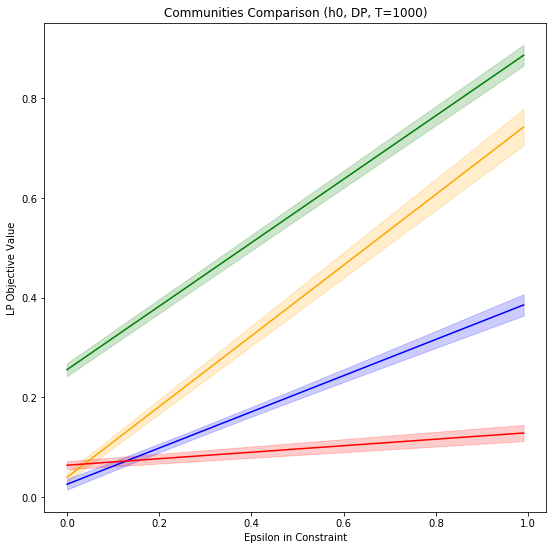

In [35]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, preprocessing_avg_objective_values, 'green')
plt.plot(epsilons, inprocessing_avg_objective_values, 'orange')
plt.plot(epsilons, postprocessing_avg_objective_values, 'blue')
plt.plot(epsilons, robust_avg_objective_values, 'red')
plt.fill_between(epsilons, preprocessing_avg_objective_values - preprocessing_std_err, preprocessing_avg_objective_values + preprocessing_std_err, color='green', alpha=0.2)
plt.fill_between(epsilons, inprocessing_avg_objective_values - inprocessing_std_err, inprocessing_avg_objective_values + inprocessing_std_err, color='orange', alpha=0.2)
plt.fill_between(epsilons, postprocessing_avg_objective_values - postprocessing_std_err, postprocessing_avg_objective_values + postprocessing_std_err, color='blue', alpha=0.2)
plt.fill_between(epsilons, robust_avg_objective_values - robust_std_err, robust_avg_objective_values + robust_std_err, color='red', alpha=0.2)
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Communities Comparison (h0, DP, T=1000)')